In [1]:
import torch
from torch import nn
from d2l import torch as d2l

定义注意力解码器

这个代码实现了带有Bahdanau注意力机制的序列到序列（Seq2Seq）模型。该模型由一个编码器（Encoder）和一个带有注意力机制的解码器（Decoder）组成。


In [2]:
'''
这个类 `AttentionDecoder` 继承自 `d2l.Decoder`，定义了带有注意力机制解码器的基本接口。
它包含一个抽象属性 `attention_weights`，用于获取注意力权重。具体实现由子类完成。
'''
class AttentionDecoder(d2l.Decoder):
    # 带有注意力机制解码器的基本接口
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    
    @property
    def attention_weights(self):
        raise NotImplementedError

In [3]:
'''
定义带有Bahdanau注意力的解码器
'''
class Seq2SeqAttentionDecoder(AttentionDecoder):
    '''
    - `self.attention`: 定义加性注意力（Additive Attention），用于计算注意力权重。
    - `self.embedding`: 定义嵌入层，将词元转换为向量。
    - `self.rnn`: 定义GRU层，输入是嵌入向量和上下文向量的连接。
    - `self.dense`: 定义全连接层，用于生成词元概率分布。
    '''
    def __init__(
        self, 
        vocab_size, 
        embed_size, 
        num_hiddens, 
        num_layers, 
        dropout=0, 
        **kwargs
    ):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout
        )
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens,
            num_hiddens,
            num_layers,
            dropout=dropout
        )
        self.dense = nn.Linear(num_hiddens, vocab_size)
    '''
    - `enc_outputs`: 编码器的输出，包括所有时间步的隐状态（outputs）和
        最后一个时间步的隐状态（hidden_state）。
    - 返回值是编码器输出、隐状态和有效长度。
    '''
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为 (batch_size, num_steps, num_hiddens)
        # hidden_state 的形状为 (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (
            outputs.permute(1, 0, 2),
            hidden_state,
            enc_valid_lens
        )

    def forward(self, X, state):
        '''
        enc_outputs的形状为(batch_size, num_steps, num_hiddens)
        hidden_state的形状为(num_layers, batch_size, num_hiddens)
        
        - `enc_outputs, hidden_state, enc_valid_lens`: 
        分别是编码器输出的隐状态、解码器的初始隐状态和编码器有效长度。
        '''
        enc_outputs, hidden_state, enc_valid_lens = state
        '''
        输出X的形状为(num_steps, batch_size, embed_size)
        - `X`: 解码器的输入，通过嵌入层转换为向量，并调整维度。
        '''
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        
        '''
        - 循环遍历解码器输入 `X` 的每个时间步：
        '''
        for x in X:
            '''
            - 计算当前解码器隐状态（`query`）和编码器输出（`enc_outputs`）的注意力权重，
              并计算上下文向量（`context`）。
              
            query的形状为(batch_size, 1, num_hiddens)
            context的形状为(batch_size, 1, num_hiddens)
            '''
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens
            )
            '''
            - 将上下文向量和当前时间步的嵌入向量连接（`x`），输入到GRU层，
              更新隐状态（`hidden_state`）和输出（`outputs`）。
            
            在特征维度上连结
            '''
            
            x = torch.cat(
                (context, torch.unsqueeze(x, dim=1)),
                dim=-1
            )
            '''
            将x形变为(1, batch_size, embed_size + num_hiddens)
            
            - 记录注意力权重。
            '''
            out, hiddens_state = self.rnn(
                x.permute(1, 0, 2),
                hidden_state
            )
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        '''
        全连接层变换后，outputs的形状为
        (num_steps, batch_size, vocab_size)
        
        - 所有时间步的输出通过全连接层（`self.dense`）生成最终输出。
        - 返回值是输出和新的状态。
        '''
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]
    '''
    注意力权重属性 `attention_weights`
    - 返回存储的注意力权重，供后续使用或可视化。
    '''
    def attention_weights(self):
        return self._attention_weights

In [4]:
'''
测试解码器

- 创建编码器和解码器实例，并设置为评估模式（`eval()`）。
'''
encoder = d2l.Seq2SeqEncoder(
    vocab_size=10,
    embed_size=8,
    num_hiddens=16,
    num_layers=2
)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(
    vocab_size=10,
    embed_size=8,
    num_hiddens=16,
    num_layers=2
)
decoder.eval()

'''
- 生成一个形状为 `(4, 7)` 的全零输入张量 `X`，表示4个序列，每个序列7个词元。
(batch_size, num_steps)
'''
X = torch.zeros(
    (4, 7), dtype=torch.long
)
'''
- 初始化解码器状态。
'''
state = decoder.init_state(
    encoder(X),
    None
)

output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape


(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

这个代码实现了一个带有Bahdanau注意力机制的Seq2Seq模型。编码器将输入序列转换为隐状态，解码器通过注意力机制在解码过程中动态调整上下文向量，生成输出序列。

---

训练

训练带有Bahdanau注意力机制的Seq2Seq模型

用Bahdanau注意力机制训练一个Seq2Seq模型进行机器翻译。这个过程包含了数据加载、模型定义和训练等步骤。

In [5]:
'''
- `embed_size`：词嵌入的维度。
- `num_hiddens`：隐藏层的单元数。
- `num_layers`：RNN的层数。
- `dropout`：Dropout的概率。
- `batch_size`：每个训练批次的样本数量。
- `num_steps`：每个序列的长度。
- `lr`：学习率。
- `num_epochs`：训练的轮数。
- `device`：训练设备，通常是GPU。
'''
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

loss 0.024, 1288.1 tokens/sec on cpu


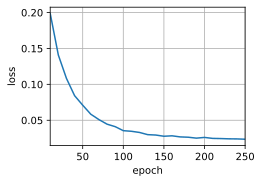

In [6]:
'''
加载数据集，这里使用的是机器翻译任务的数据集
- `train_iter`：训练数据迭代器。
- `src_vocab`：源语言词汇表。
- `tgt_vocab`：目标语言词汇表。
'''
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

'''
定义编码器和解码器，并将它们结合到一个整体的Seq2Seq模型中

- `encoder`：编码器，将源语言序列编码成上下文向量。
'''
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab),
    embed_size,
    num_hiddens,
    num_layers,
    dropout
)
'''
- `decoder`：解码器，使用注意力机制将上下文向量解码成目标语言序列。
'''
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab),
    embed_size,
    num_hiddens,
    num_layers,
    dropout
)
'''
- `net`：Seq2Seq模型，将编码器和解码器组合在一起。
'''
net = d2l.EncoderDecoder(encoder, decoder)

'''
- `net`：要训练的Seq2Seq模型。
- `train_iter`：训练数据迭代器。
- `lr`：学习率。
- `num_epochs`：训练轮数。
- `tgt_vocab`：目标语言词汇表。
- `device`：训练设备。
'''

d2l.train_seq2seq(
    net,
    train_iter, 
    lr,
    num_epochs,
    tgt_vocab,
    device
)

In [7]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

In [8]:
'''
- `engs`：一组英语句子。
- `fras`：对应的法语翻译。
- `translation`：模型生成的翻译结果。
- `dec_attention_weight_seq`：解码器的注意力权重序列。
- `d2l.bleu`：计算BLEU分数，衡量翻译的准确性。
'''
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True
    )
    print(
        f'{eng} => {translation}',
        f'bleu {d2l.bleu(translation, fra, k=2):.3f}'
    )
'''
通过以上步骤，我们成功地定义并训练了一个带有Bahdanau注意力机制的Seq2Seq模型用于机器翻译任务。
这个过程包括设置超参数、加载数据、定义模型、训练模型以及评估模型的翻译效果。
'''

go . => va ! bleu 1.000
i lost . => j'ai perdu . bleu 1.000
he's calm . => il est paresseux . bleu 0.658
i'm home . => je suis chez moi . bleu 1.000


'\n通过以上步骤，我们成功地定义并训练了一个带有Bahdanau注意力机制的Seq2Seq模型用于机器翻译任务。\n这个过程包括设置超参数、加载数据、定义模型、训练模型以及评估模型的翻译效果。\n'